In [1]:
import sqlite3
import logging
import pandas as pd
from urllib.parse import urlparse
from tld import get_tld, get_fld
from matplotlib import pyplot as plt
from http.cookies import SimpleCookie

plt.rcParams['figure.figsize'] = [20, 10]


In [2]:
# Specify your local path to the sqlite db containing crawl data
SQLITE_LOCAL_PATH = '/Users/liam/dev/OpenWPM/data/gemeente_social_complete.sqlite'
SM_FLDS = ['facebook', 'instagram', 'linkedin', 'google', 'youtube', 'twitter', 'twimg', 'fbcdn']

In [3]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(SQLITE_LOCAL_PATH)

cursor = con.cursor()

# Parse javascript table from SQLite
javascript = pd.read_sql_query("SELECT * from javascript", con)
# Parse SITE_VISITS table from SQLite
site_visits = pd.read_sql_query("SELECT * from site_visits", con)

#Drop what we don't need
javascript = javascript.drop(["script_loc_eval", "page_scoped_event_ordinal", "event_ordinal", "id", "incognito", "frame_id", "script_line", "script_col", "crawl_id", "extension_session_uuid", "tab_id", "window_id"], axis=1)

print(javascript.columns)
print(site_visits.columns)

Index(['visit_id', 'script_url', 'func_name', 'document_url', 'top_level_url',
       'call_stack', 'symbol', 'operation', 'value', 'arguments',
       'time_stamp'],
      dtype='object')
Index(['visit_id', 'crawl_id', 'site_url', 'parent_url'], dtype='object')


In [4]:
# Join the site_visits information into the javascript for a complete dataset and we can select columns next
all_columns = javascript.set_index('visit_id').join(site_visits.set_index('visit_id'), lsuffix='_javascript', rsuffix='_site_visits')

# More filtering of columns
js_analysis_set = all_columns[["script_url", "top_level_url", "symbol", "operation", "value", "arguments", "time_stamp", "site_url", "parent_url"]]

_temp_replace = js_analysis_set.copy()['parent_url'].apply(lambda s: s.replace(' ', ''))
javascript_analysis_set = js_analysis_set.copy()
javascript_analysis_set['parent_url'] = _temp_replace.copy()

In [5]:
# Helper function to get TLD+1 level of crawled link.
def parse_tld_url(url):
    return get_fld(url, fail_silently=True)

js_analysis = javascript_analysis_set.copy()

#Get the script_url's top level domain into script_url_tld
js_analysis['script_url_tld'] = js_analysis.copy()['script_url'].apply(parse_tld_url)
js_analysis['site_url_tld'] = js_analysis.copy()['site_url'].apply(parse_tld_url)
js_analysis['parent_url_tld'] = js_analysis.copy()['parent_url'].apply(parse_tld_url)

# parent_url (the top level gemeente site) -> site_url (gemeente site or one link off gemeente) -> script_url (js event hosted by)
js_analysis.to_csv("parent_site_and_script_url_FULL.csv")


In [6]:
js_analysis.iloc[3010]
#Need to remove any trailing whitespace from parent URL before putting it in parent_url_tld

script_url                 https://logging.simanalytics.nl/piwik.js
top_level_url     https://www.aalten.nl/inwoners/verhuizen-en-ui...
symbol                                       window.document.cookie
operation                                                       get
value             _pk_ses.12.0771=*; _pk_id.12.0771=75728710ee1e...
arguments                                                      None
time_stamp                                 2019-05-15T21:50:32.242Z
site_url          http://www.aalten.nl/inwoners/verhuizen-en-uit...
parent_url                                     http://www.aalten.nl
script_url_tld                                      simanalytics.nl
site_url_tld                                              aalten.nl
parent_url_tld                                            aalten.nl
Name: 31, dtype: object

In [7]:
def top_script_url_tld(script_url_cookies):
    # Let's create a new column with the script_url stripped to top level domain
    return script_url_cookies.copy()[['script_url_tld', 'parent_url']]\
        .groupby('script_url_tld')\
        .count()\
        .sort_values(by=['parent_url'], ascending=False)\
#         .head(20)

top_script_url_tld(js_analysis).to_csv("third_party_js_script_url_FULL.csv")
top_script_url_tld(js_analysis)

,parent_url
script_url_tld,
google-analytics.com,87130
twimg.com,70032
readspeaker.com,67568
fbcdn.net,65029
simanalytics.nl,56947
instagram.com,47317
youtube.com,38701
siteimproveanalytics.com,14047
licdn.com,11722


In [8]:
# Let's reduce to three columns, group by javascript symbol and operation, count and sort ascending...
# This will tell us the frequency of various javascript actions 
javascript_analysis_set[ ['symbol', 'operation', 'parent_url']]\
    .groupby(['symbol', 'operation'])\
    .count()\
    .sort_values(by=['parent_url'], ascending=False)\
    .head(20)


,,parent_url
symbol,operation,
window.document.cookie,get,148154
window.navigator.userAgent,get,89784
window.Storage.getItem,call,43764
window.document.referrer,get,33144
window.document.cookie,set,30740
window.sessionStorage,get,27072
window.Storage.setItem,call,23325
window.localStorage,get,19606
window.Storage.removeItem,call,12739


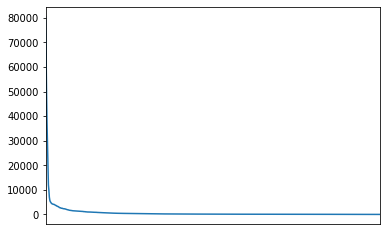

twitter.com           80449
facebook.com          67626
instagram.com         50553
lansingerland.nl      37764
youtube.com           29064
t.co                  19831
linkedin.com          12056
heumen.nl              9921
amsterdam.nl           7023
emmenmaakhetmee.nl     5782
Name: site_url_tld, dtype: int64

In [9]:
plot = js_analysis.copy()['site_url_tld'].value_counts().plot.line()
plot.axes.get_xaxis().set_visible(False)
plt.show()

# What type of site_tlds have the most javascript events...
js_analysis['site_url_tld'].value_counts().head(10)


In [10]:
social_sites_js_analysis = js_analysis[ js_analysis['script_url_tld'].str.contains('|'.join(SM_FLDS), na=False) ]

In [11]:
def extract_cookie_keys(cookie_string):
    try:
        cookie = SimpleCookie()
        cookie.load(cookie_string)
        unpacked = [{"key": k, "morsel": m} for k, m in cookie.items()]
        morsel_keys = [c.get('morsel').key for c in unpacked]
        return morsel_keys
    except Exception as e: 
        return []

ss_js_analysis = social_sites_js_analysis.copy()    
    
# Add a column which contains all of the cookie keys from the javascript event row
ss_js_analysis['cookie_keys'] = ss_js_analysis['value'].apply(extract_cookie_keys)

# Remove any rows that have no cookie_keys
ss_js_analysis = ss_js_analysis[ss_js_analysis['cookie_keys'].map(lambda d: len(d)) > 0]

ss_js_analysis

,script_url,top_level_url,symbol,operation,value,arguments,time_stamp,site_url,parent_url,script_url_tld,site_url_tld,parent_url_tld,cookie_keys
visit_id,,,,,,,,,,,,,
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.959Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.960Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.960Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.963Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.963Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.964Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.964Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.966Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.966Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]


In [14]:
only_gementee_sub_pages = ss_js_analysis.loc[ss_js_analysis['site_url_tld'] == ss_js_analysis['parent_url_tld']]

In [15]:
only_gementee_sub_pages

,script_url,top_level_url,symbol,operation,value,arguments,time_stamp,site_url,parent_url,script_url_tld,site_url_tld,parent_url_tld,cookie_keys
visit_id,,,,,,,,,,,,,
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.959Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.960Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.960Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.963Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.963Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.964Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.964Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.966Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.966Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js]


In [19]:
g_sub_pages = only_gementee_sub_pages.copy()
columns = list(g_sub_pages.columns) + ['cookie_key']
with_every_cookie = pd.DataFrame(columns=columns)

# How do I unstack all of this? 
# https://stackoverflow.com/questions/53218931/how-to-unnest-explode-a-column-in-a-pandas-dataframe
# My solution is NOT performant

counter = 0
print(g_sub_pages.shape)
for index, row in g_sub_pages.iterrows():
    counter += 1
    for k in row['cookie_keys']:
        row['cookie_key'] = k
        with_every_cookie = with_every_cookie.append(row)
    if counter % 1000 == 0:
        print(counter)

with_every_cookie

(27932, 13)
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


,script_url,top_level_url,symbol,operation,value,arguments,time_stamp,site_url,parent_url,script_url_tld,site_url_tld,parent_url_tld,cookie_keys,cookie_key
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.959Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js],has_js
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.960Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js],has_js
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.960Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js],has_js
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.963Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js],has_js
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.963Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js],has_js
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.964Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js],has_js
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.964Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js],has_js
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.966Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js],has_js
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.966Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[has_js],has_js
2,https://www.google-analytics.com/analytics.js,https://gemeente.groningen.nl/belastingen,window.document.cookie,set,_ga=GA1.2.318835241.1557956941; path=/; expire...,None,2019-05-15T21:49:02.966Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,google-analytics.com,groningen.nl,groningen.nl,[_ga],_ga


In [36]:
with_every_cookie.cookie_key.value_counts().head(100)

with_every_cookie.groupby('parent_url_tld')['cookie_key'].value_counts().sort_values(ascending=False)

parent_url_tld       cookie_key             
heumen.nl            _ga                        1703
                     _gid                       1688
amsterdam.nl         _ga                        1584
                     _gid                       1569
heumen.nl            _pk_ses.85.a427            1553
                     _pk_id.85.a427             1553
amsterdam.nl         cookies_consent            1351
                     nmstat                     1322
heumen.nl            _gat                       1302
amsterdam.nl         _gat_Var_368               1290
beesel.nl            _ga                        1144
                     _gid                       1132
amsterdam.nl         _gat                       1120
beesel.nl            __sqrc                     1006
                     __sqra                     1006
                     __sqrb                     1006
vaals.nl             _ga                         969
beesel.nl            _gat_gtag_UA_63124694_1     968
v

In [37]:
results = with_every_cookie[ with_every_cookie['script_url_tld'].str.contains('|'.join(SM_FLDS), na=False) ]


In [40]:

pd.set_option('display.max_rows', 500)
results.cookie_key.value_counts().head(100)
results.groupby('parent_url_tld')['cookie_key'].value_counts().sort_values(ascending=False)

parent_url_tld           cookie_key              
heumen.nl                _ga                         1703
                         _gid                        1688
amsterdam.nl             _ga                         1584
                         _gid                        1569
heumen.nl                _pk_ses.85.a427             1553
                         _pk_id.85.a427              1553
amsterdam.nl             cookies_consent             1351
                         nmstat                      1322
heumen.nl                _gat                        1302
amsterdam.nl             _gat_Var_368                1290
beesel.nl                _ga                         1144
                         _gid                        1132
amsterdam.nl             _gat                        1120
beesel.nl                __sqrc                      1006
                         __sqra                      1006
                         __sqrb                      1006
vaals.nl              

In [41]:
_fbp = results[results.value.str.contains('_fbp')]
_fbp.site_url_tld

,script_url,top_level_url,symbol,operation,value,arguments,time_stamp,site_url,parent_url,script_url_tld,site_url_tld,parent_url_tld,cookie_keys,cookie_key,sm_origin_script
1137,https://connect.facebook.net/signals/config/12...,https://www.deventerverkoopt.nl/,window.document.cookie,set,_fbp=fb.0.1557959926426.1091208978;expires=Tue...,None,2019-05-15T22:38:46.558Z,https://www.deventer.nl/themawebsites/themaweb...,http://www.deventer.nl,facebook.net,deventer.nl,deventer.nl,[_fbp],_fbp,False
1137,https://connect.facebook.net/signals/config/12...,https://www.deventerverkoopt.nl/,window.document.cookie,set,_fbp=fb.1.1557959926426.1091208978;expires=Tue...,None,2019-05-15T22:38:46.559Z,https://www.deventer.nl/themawebsites/themaweb...,http://www.deventer.nl,facebook.net,deventer.nl,deventer.nl,[_fbp],_fbp,False
1137,https://connect.facebook.net/signals/config/12...,https://www.deventerverkoopt.nl/,window.document.cookie,get,PHPSESSID=egcnc623mfnm89ttvev9qft240; _ga=GA1....,None,2019-05-15T22:38:46.560Z,https://www.deventer.nl/themawebsites/themaweb...,http://www.deventer.nl,facebook.net,deventer.nl,deventer.nl,"[PHPSESSID, _ga, _gid, _gat, _fbp]",PHPSESSID,False
1137,https://connect.facebook.net/signals/config/12...,https://www.deventerverkoopt.nl/,window.document.cookie,get,PHPSESSID=egcnc623mfnm89ttvev9qft240; _ga=GA1....,None,2019-05-15T22:38:46.560Z,https://www.deventer.nl/themawebsites/themaweb...,http://www.deventer.nl,facebook.net,deventer.nl,deventer.nl,"[PHPSESSID, _ga, _gid, _gat, _fbp]",_ga,False
1137,https://connect.facebook.net/signals/config/12...,https://www.deventerverkoopt.nl/,window.document.cookie,get,PHPSESSID=egcnc623mfnm89ttvev9qft240; _ga=GA1....,None,2019-05-15T22:38:46.560Z,https://www.deventer.nl/themawebsites/themaweb...,http://www.deventer.nl,facebook.net,deventer.nl,deventer.nl,"[PHPSESSID, _ga, _gid, _gat, _fbp]",_gid,False
1137,https://connect.facebook.net/signals/config/12...,https://www.deventerverkoopt.nl/,window.document.cookie,get,PHPSESSID=egcnc623mfnm89ttvev9qft240; _ga=GA1....,None,2019-05-15T22:38:46.560Z,https://www.deventer.nl/themawebsites/themaweb...,http://www.deventer.nl,facebook.net,deventer.nl,deventer.nl,"[PHPSESSID, _ga, _gid, _gat, _fbp]",_gat,False
1137,https://connect.facebook.net/signals/config/12...,https://www.deventerverkoopt.nl/,window.document.cookie,get,PHPSESSID=egcnc623mfnm89ttvev9qft240; _ga=GA1....,None,2019-05-15T22:38:46.560Z,https://www.deventer.nl/themawebsites/themaweb...,http://www.deventer.nl,facebook.net,deventer.nl,deventer.nl,"[PHPSESSID, _ga, _gid, _gat, _fbp]",_fbp,False
1137,https://connect.facebook.net/signals/config/12...,https://www.deventerverkoopt.nl/,window.document.cookie,get,PHPSESSID=egcnc623mfnm89ttvev9qft240; _ga=GA1....,None,2019-05-15T22:38:48.078Z,https://www.deventer.nl/themawebsites/themaweb...,http://www.deventer.nl,facebook.net,deventer.nl,deventer.nl,"[PHPSESSID, _ga, _gid, _gat, _fbp]",PHPSESSID,False
1137,https://connect.facebook.net/signals/config/12...,https://www.deventerverkoopt.nl/,window.document.cookie,get,PHPSESSID=egcnc623mfnm89ttvev9qft240; _ga=GA1....,None,2019-05-15T22:38:48.078Z,https://www.deventer.nl/themawebsites/themaweb...,http://www.deventer.nl,facebook.net,deventer.nl,deventer.nl,"[PHPSESSID, _ga, _gid, _gat, _fbp]",_ga,False
1137,https://connect.facebook.net/signals/config/12...,https://www.deventerverkoopt.nl/,window.document.cookie,get,PHPSESSID=egcnc623mfnm89ttvev9qft240; _ga=GA1....,None,2019-05-15T22:38:48.078Z,https://www.deventer.nl/themawebsites/themaweb...,http://www.deventer.nl,facebook.net,deventer.nl,deventer.nl,"[PHPSESSID, _ga, _gid, _gat, _fbp]",_gid,False
